In [14]:


import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from loader import load_as_df
from clustering.add_class_to_data import CLUSTERS_ADDED
from xgboost import XGBRegressor
import cupy as cp


In [2]:
df_all = load_as_df('20220101', '20221231').dropna()
df_all.landcover = df_all.landcover.astype(str)
df_all = pd.concat([df_all, pd.get_dummies(df_all.landcover)], axis=1)
df_all = df_all.drop(columns=['timestamp_lst', 'rounded_timestamps', 'landcover'])

In [6]:
df = df_all.sample(500_000, axis=0)

cluster_to_keep = '7'
cluster_to_drops = [elem for elem in CLUSTERS_ADDED if elem !=cluster_to_keep]

X = df.drop(columns=['soil_moisture'])
y = df['soil_moisture']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
def get_ubrmse(pred, y):
    error = y - pred
    mse = mean_squared_error(y, pred)
    rmse = math.sqrt(mse)
    bias = np.mean(error)
    return math.sqrt(rmse ** 2 - bias ** 2)


def create_fig(param_name, param_values, suffix=''):
    train_results = []
    test_results = []
    for v in param_values:
        if param_name != 'CLUSTER' :
            xgb = XGBRegressor(n_jobs=-1, **{param_name: v})
            x_train = X_train.drop(columns=cluster_to_drops)
            x_test = X_test.drop(columns=cluster_to_drops)
        else:
            xgb = XGBRegressor(n_jobs=-1)
            x_train = X_train.drop(columns=[elem for elem in CLUSTERS_ADDED if elem !=v])
            x_test = X_test.drop(columns=[elem for elem in CLUSTERS_ADDED if elem !=v])
        
        xgb.fit(x_train, y_train)
        train_pred = xgb.predict(x_train)

        train_ubrmse = get_ubrmse(train_pred, y_train)

        train_results.append(train_ubrmse)

        y_pred = xgb.predict(x_test)
        test_ubrmse = get_ubrmse(y_pred, y_test)

        test_results.append(test_ubrmse)

    line1, = plt.plot(param_values, train_results, 'b', label='Train')
    line2, = plt.plot(param_values, test_results, 'r', label='Test')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('ubRMSE')
    plt.xlabel(f'{param_name}')
    pd.DataFrame({param_name: param_values, 'train': train_results, 'test': test_results}).to_csv(
        f'../figures/xgb/xgp_{param_name + suffix}.csv')
    plt.savefig(f'../figures/xgb/xgb_{param_name + suffix}.svg')

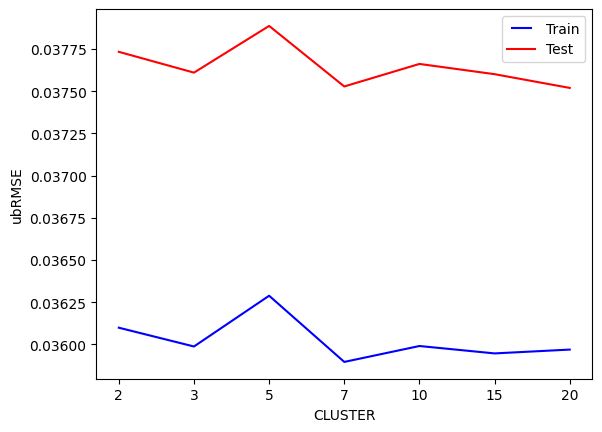

In [22]:
create_fig('CLUSTER', CLUSTERS_ADDED)

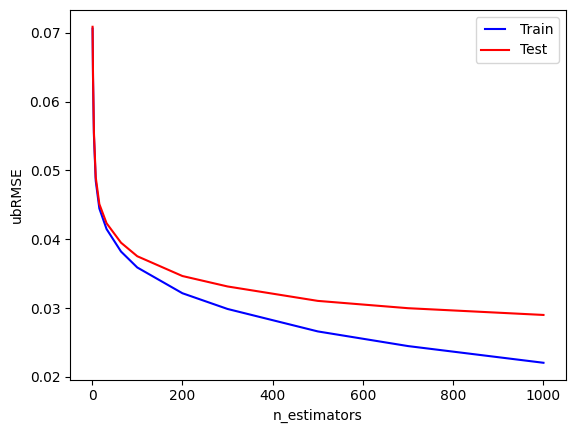

In [23]:
create_fig('n_estimators', [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 500, 700, 1000])

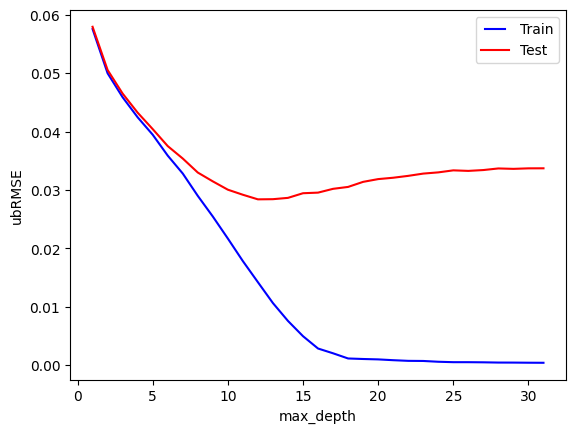

In [10]:
create_fig('max_depth', np.arange(1, 32, 1))

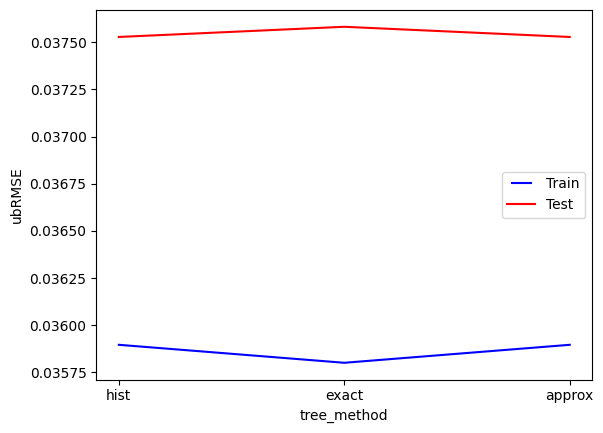

In [11]:
create_fig('tree_method', ['hist', 'exact', 'approx'])

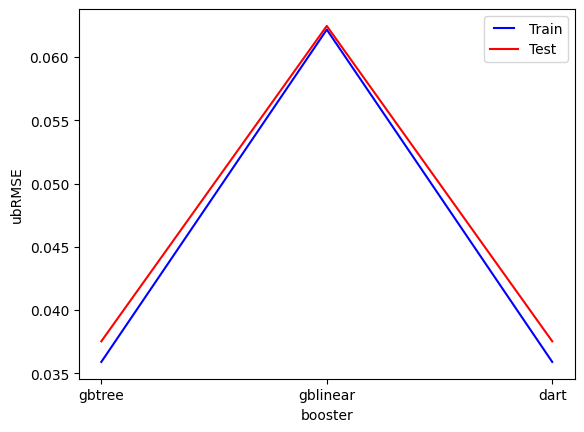

In [12]:
create_fig('booster', ['gbtree', 'gblinear', 'dart'])

In [33]:
# Number of trees in random forest
n_estimators = [50, 100, 300, 500, 1000]
# Maximum number of levels in tree
max_depth = [5, 10, 13, 15, 17]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'booster': ['gbtree'],
              'tree_method': ['hist']}
xgb = XGBRegressor(verbosity=0, n_jobs=1)
xgb_random = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, verbose=3, n_jobs=-1)
xgb_random.fit(X.drop(columns=cluster_to_drops), y)
print('')

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [34]:
res_df = pd.DataFrame(xgb_random.cv_results_)
res_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_max_depth,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,166.230297,7.020396,39.150123,1.780475,gbtree,10,1000,hist,"{'booster': 'gbtree', 'max_depth': 10, 'n_esti...",0.887417,0.885941,0.887506,0.886955,0.000718,1
8,89.661621,5.130366,19.381624,0.712585,gbtree,10,500,hist,"{'booster': 'gbtree', 'max_depth': 10, 'n_esti...",0.884805,0.883242,0.885262,0.884436,0.000865,2
7,50.999384,1.109404,10.372125,0.162379,gbtree,10,300,hist,"{'booster': 'gbtree', 'max_depth': 10, 'n_esti...",0.880616,0.879134,0.881403,0.880384,0.000941,3
14,179.506074,4.648361,34.047149,0.727871,gbtree,13,1000,hist,"{'booster': 'gbtree', 'max_depth': 13, 'n_esti...",0.878697,0.876585,0.878706,0.877996,0.000998,4
13,163.239614,1.321668,30.762578,0.263550,gbtree,13,500,hist,"{'booster': 'gbtree', 'max_depth': 13, 'n_esti...",0.878697,0.876585,0.878706,0.877996,0.000998,5
12,131.176441,3.841517,21.552913,0.170634,gbtree,13,300,hist,"{'booster': 'gbtree', 'max_depth': 13, 'n_esti...",0.878264,0.876202,0.878356,0.877607,0.000995,6
11,52.091507,0.383325,9.621067,0.106685,gbtree,13,100,hist,"{'booster': 'gbtree', 'max_depth': 13, 'n_esti...",0.873793,0.871388,0.873749,0.872976,0.001123,7
19,182.911665,5.078561,21.991483,0.923867,gbtree,15,1000,hist,"{'booster': 'gbtree', 'max_depth': 15, 'n_esti...",0.869767,0.866004,0.869737,0.868503,0.001767,8
18,182.034190,3.487670,23.040305,2.173711,gbtree,15,500,hist,"{'booster': 'gbtree', 'max_depth': 15, 'n_esti...",0.869767,0.866004,0.869737,0.868503,0.001767,9
17,183.270596,8.035174,17.075965,1.900685,gbtree,15,300,hist,"{'booster': 'gbtree', 'max_depth': 15, 'n_esti...",0.869767,0.866004,0.869737,0.868503,0.001767,10


In [26]:
# Number of trees in random forest
n_estimators = [50]
# Number of features to consider at every split
max_features = [6, 8, 10]
# Maximum number of levels in tree
max_depth = [20, 25]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}
xgb = RandomForestRegressor()
xgb_random_2 = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
xgb_random_2.fit(X.drop(columns=cluster_to_drops), y)
print('')

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [27]:
res_2_df = pd.DataFrame(xgb_random_2.cv_results_)
res_2_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,34.747533,0.494205,0.240804,0.004956,25,10,2,4,50,"{'max_depth': 25, 'max_features': 10, 'min_sam...",0.755617,0.749086,0.751834,0.752179,0.002677,1
8,34.900501,0.813476,0.267109,0.003089,20,10,2,4,50,"{'max_depth': 20, 'max_features': 10, 'min_sam...",0.753274,0.749783,0.749532,0.750863,0.001708,2
16,29.335553,0.211230,0.280078,0.010403,25,8,2,4,50,"{'max_depth': 25, 'max_features': 8, 'min_samp...",0.753093,0.744890,0.746893,0.748292,0.003492,3
21,33.221954,0.241228,0.222510,0.006769,25,10,2,10,50,"{'max_depth': 25, 'max_features': 10, 'min_sam...",0.746932,0.745094,0.748031,0.746686,0.001211,4
9,33.520950,0.350749,0.235648,0.002208,20,10,2,10,50,"{'max_depth': 20, 'max_features': 10, 'min_sam...",0.749933,0.741683,0.743558,0.745058,0.003531,5
4,27.661658,0.328685,0.269723,0.002049,20,8,2,4,50,"{'max_depth': 20, 'max_features': 8, 'min_samp...",0.748482,0.741303,0.741988,0.743924,0.003235,6
23,30.996177,0.142936,0.213201,0.007604,25,10,5,10,50,"{'max_depth': 25, 'max_features': 10, 'min_sam...",0.746327,0.739855,0.744630,0.743604,0.002740,7
10,31.848551,0.635100,0.261978,0.037572,20,10,5,4,50,"{'max_depth': 20, 'max_features': 10, 'min_sam...",0.746145,0.740483,0.741225,0.742617,0.002512,8
22,31.733198,0.457428,0.216691,0.008295,25,10,5,4,50,"{'max_depth': 25, 'max_features': 10, 'min_sam...",0.744466,0.742098,0.740827,0.742464,0.001508,9
17,28.376474,0.362148,0.261239,0.024668,25,8,2,10,50,"{'max_depth': 25, 'max_features': 8, 'min_samp...",0.744548,0.742396,0.739973,0.742306,0.001869,10


In [28]:
# Number of trees in random forest
n_estimators = [50]
# Number of features to consider at every split
max_features = [2, 4, 6]
# Maximum number of levels in tree
max_depth = [20, 25]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}
xgb = RandomForestRegressor()
xgb_random_3 = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
xgb_random_3.fit(X.drop(columns=cluster_to_drops), y)
print('')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [29]:
res_3_df = pd.DataFrame(xgb_random_3.cv_results_)
res_3_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,17.538205,0.025474,0.209886,0.002287,25,6,2,10,50,"{'max_depth': 25, 'max_features': 6, 'min_samp...",0.738709,0.732268,0.734302,0.735093,0.002688,1
2,16.745334,0.075520,0.194804,0.003415,20,6,2,10,50,"{'max_depth': 20, 'max_features': 6, 'min_samp...",0.732454,0.729869,0.731477,0.731267,0.001066,2
4,12.563995,0.086494,0.216398,0.007888,25,4,2,10,50,"{'max_depth': 25, 'max_features': 4, 'min_samp...",0.716808,0.714156,0.712019,0.714328,0.001959,3
1,11.995836,0.046956,0.220107,0.011893,20,4,2,10,50,"{'max_depth': 20, 'max_features': 4, 'min_samp...",0.715664,0.705300,0.710352,0.710439,0.004232,4
3,7.082327,0.058845,0.263959,0.031569,25,2,2,10,50,"{'max_depth': 25, 'max_features': 2, 'min_samp...",0.665193,0.657222,0.662081,0.661499,0.003280,5
0,6.696144,0.038292,0.247226,0.018492,20,2,2,10,50,"{'max_depth': 20, 'max_features': 2, 'min_samp...",0.656632,0.657832,0.656761,0.657075,0.000538,6


In [35]:
pd.get_dummies(X_train['landcover'])

,10.0,100.0,11.0,110.0,120.0,122.0,130.0,150.0,170.0,180.0,190.0,20.0,200.0,30.0,40.0,50.0,60.0,62.0
3373582,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
167504,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
474817,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
10153973,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
14656100,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13092725,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
6609968,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5957503,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
8461777,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
